In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from itertools import product
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

In [114]:
# Load the training data

train_data = pd.read_csv('train_sun.csv')

In [115]:
# Preprocess data
train_data['Month'] = pd.to_datetime(train_data['Month'], format='%m-%d-%Y')
train_data.set_index('Month', inplace=True)

In [116]:
# Split the data into a training set and a validation set (e.g., last 10% for validation)
train_size = int(len(train_data) * 0.9)  # Use 90% for training, 10% for validation
train, validation = train_data[:train_size], train_data[train_size:]

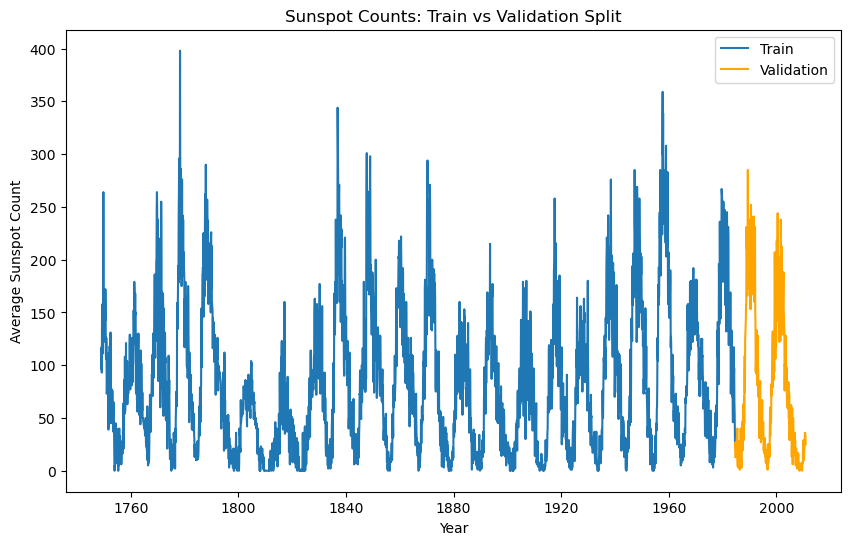

In [117]:
# Visualize the training and validation split
plt.figure(figsize=(10,6))
plt.plot(train['Avg_sunspot_count'], label='Train')
plt.plot(validation['Avg_sunspot_count'], label='Validation', color='orange')
plt.title('Sunspot Counts: Train vs Validation Split')
plt.xlabel('Year')
plt.ylabel('Average Sunspot Count')
plt.legend()
plt.show()

In [118]:
# Function to perform the Augmented Dickey-Fuller test for stationarity
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print("The series is stationary")
    else:
        print("The series is not stationary")


In [119]:
# Perform the ADF test on the training data to check stationarity
adf_test(train['Avg_sunspot_count'])

ADF Statistic: -9.673731609927469
p-value: 1.256851749092944e-16
The series is stationary


In [120]:
# Define parameter ranges for SARIMA model
p = d = q = range(0, 3)  # Regular SARIMA parameters
P = D = Q = range(0, 2)  # Seasonal parameters
m = [12]  # Seasonal period (monthly data)

In [121]:
# Generate all possible combinations of (p, d, q) x (P, D, Q, m)
param_combinations = list(product(p, d, q, P, D, Q, m))

In [122]:
# Initialize variables to store best model and RMSE
best_rmse = float('inf')
best_params = None

In [123]:
# Grid search for the best SARIMA parameters
for param in param_combinations:
    try:
        # Build SARIMA model with the current parameters
        model = SARIMAX(train['Avg_sunspot_count'], 
                        order=(param[0], param[1], param[2]),
                        seasonal_order=(param[3], param[4], param[5], param[6]),
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        
        # Fit the SARIMA model
        sarima_model = model.fit(disp=False)
        
        # Optionally, you can print or log the summary to check the model performance
        print(f"Model with parameters {param} fitted successfully.")
        
    except ValueError as ve:
        print(f"ValueError for parameters {param}: {ve}")
    except Exception as e:
        print(f"Error for parameters {param}: {e}")

Model with parameters (0, 0, 0, 0, 0, 0, 12) fitted successfully.
Model with parameters (0, 0, 0, 0, 0, 1, 12) fitted successfully.
Model with parameters (0, 0, 0, 0, 1, 0, 12) fitted successfully.
Model with parameters (0, 0, 0, 0, 1, 1, 12) fitted successfully.
Model with parameters (0, 0, 0, 1, 0, 0, 12) fitted successfully.
Model with parameters (0, 0, 0, 1, 0, 1, 12) fitted successfully.
Model with parameters (0, 0, 0, 1, 1, 0, 12) fitted successfully.
Model with parameters (0, 0, 0, 1, 1, 1, 12) fitted successfully.
Model with parameters (0, 0, 1, 0, 0, 0, 12) fitted successfully.
Model with parameters (0, 0, 1, 0, 0, 1, 12) fitted successfully.
Model with parameters (0, 0, 1, 0, 1, 0, 12) fitted successfully.
Model with parameters (0, 0, 1, 0, 1, 1, 12) fitted successfully.
Model with parameters (0, 0, 1, 1, 0, 0, 12) fitted successfully.
Model with parameters (0, 0, 1, 1, 0, 1, 12) fitted successfully.
Model with parameters (0, 0, 1, 1, 1, 0, 12) fitted successfully.
Model with

In [137]:
# Make predictions on the validation set
forecasted_values = sarima_model.predict(start=validation.index[0], end=validation.index[-1])
forecasted_values = forecasted_values[:len(validation)]  # Ensure alignment

In [138]:
# Calculate RMSE between actual validation data and predicted values
rmse = np.sqrt(mean_squared_error(validation['Avg_sunspot_count'], forecasted_values))
print(f"Root Mean Squared Error (RMSE): {rmse}")



Root Mean Squared Error (RMSE): 854.990962665779


In [139]:
 for param in param_combinations:  
    try:
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(validation['Avg_sunspot_count'], forecasted_values))
        
        # Update the best model if current RMSE is lower
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = param 
            
    except Exception as e:
        continue  # Ignore models that fail

# Print statements outside of the try-except block
print(f"Best RMSE: {best_rmse}")
print(f"Best SARIMA Parameters: {best_params}")

Best RMSE: 854.990962665779
Best SARIMA Parameters: (0, 0, 0, 0, 0, 0, 12)


In [144]:
# Now fit the model on the full dataset using the best parameters
model_full = SARIMAX(train_data['Avg_sunspot_count'], 
                     order=(best_params[0], best_params[1], best_params[2]), 
                     seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]),
                     enforce_stationarity=False, 
                     enforce_invertibility=False)
sarima_model_full = model_full.fit(disp=False)


In [146]:
# Now fit the model on the full dataset and make predictions for the test data
test_data_path = 'test_sun.csv'
test_data = pd.read_csv(test_data_path)

In [148]:
 #Preprocess test data
test_data['Month'] = pd.to_datetime(test_data['Month'], format='%m-%d-%Y')
test_data.set_index('Month', inplace=True)

In [150]:
# Forecast for the test data
test_forecast = sarima_model_full.predict(start=test_data.index[0], end=test_data.index[-1])

In [152]:
# Prepare the final output to match the 'sample_submission' file format
submission = pd.DataFrame({
    'Month': test_data.index.strftime('%m-%d-%Y'),  # Ensure 'Month' column in 'MM-DD-YYYY' format
    'Avg_sunspot_count': test_forecast.round(0).astype(int)  # Round to nearest integer
})


In [154]:
# Save the results to a CSV file with the correct format
submission.to_csv('sunspot_forecast_submission.csv', index=False)

print("Forecast saved as 'sunspot_forecast_submission.csv'")

Forecast saved as 'sunspot_forecast_submission.csv'
